In [48]:
import pandas as pd 

from great_expectations.data_context import FileDataContext
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
import xgboost as xgb

from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from scipy.stats import f_oneway, pearsonr
import pickle

import scipy.stats as stats
from ucimlrepo import fetch_ucirepo 
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import sklearn
from sklearn.model_selection import RandomizedSearchCV



## Data Loading

In [49]:
df = pd.read_csv('retail_store_inventory.csv')

### Data exploration

The following is prelimenary explorations for checks of eronious/problematic data.. Mising data/incorrect field types, and also to plan next steps

In [50]:
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

### Cleaning column header

In [51]:
df.columns = df.columns.str.replace(' ', '_').str.replace('/', 'or')

In [52]:
df.columns

Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'HolidayorPromotion',
       'Competitor_Pricing', 'Seasonality'],
      dtype='object')

Printing out the first few data to see data structure

In [53]:
df.head()

,Date,Store_ID,Product_ID,Category,Region,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,Weather_Condition,HolidayorPromotion,Competitor_Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [54]:
df.tail()

,Date,Store_ID,Product_ID,Category,Region,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,Weather_Condition,HolidayorPromotion,Competitor_Pricing,Seasonality
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,20,Rainy,1,79.52,Spring


from the following we can see that the date is sequential

In [55]:
df.nunique()

Date                    731
Store_ID                  5
Product_ID               20
Category                  5
Region                    4
Inventory_Level         451
Units_Sold              498
Units_Ordered           181
Demand_Forecast       31608
Price                  8999
Discount                  5
Weather_Condition         4
HolidayorPromotion        2
Competitor_Pricing     9751
Seasonality               4
dtype: int64

from the following we can see that the likely columns that are categorical are for Seasonality, HolidayorPromotion, Weather_Condition, Discount, Region, Category,  product ID and store ID

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store_ID            73100 non-null  object 
 2   Product_ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory_Level     73100 non-null  int64  
 6   Units_Sold          73100 non-null  int64  
 7   Units_Ordered       73100 non-null  int64  
 8   Demand_Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather_Condition   73100 non-null  object 
 12  HolidayorPromotion  73100 non-null  int64  
 13  Competitor_Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

from the following date is not datetime so we must change that

In [57]:
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') 

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store_ID            73100 non-null  object        
 2   Product_ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory_Level     73100 non-null  int64         
 6   Units_Sold          73100 non-null  int64         
 7   Units_Ordered       73100 non-null  int64         
 8   Demand_Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather_Condition   73100 non-null  object        
 12  HolidayorPromotion  73100 non-null  int64         
 13  Competitor_Pricing  73100 non-null  float64   

In [59]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Inventory_Level,73100.0,274.47,129.95,50.00,162.00,273.00,387.00,500.00
Units_Sold,73100.0,136.46,108.92,0.00,49.00,107.00,203.00,499.00
Units_Ordered,73100.0,110.00,52.28,20.00,65.00,110.00,155.00,200.00
Demand_Forecast,73100.0,141.49,109.25,-9.99,53.67,113.02,208.05,518.55
Price,73100.0,55.14,26.02,10.00,32.65,55.05,77.86,100.00
Discount,73100.0,10.01,7.08,0.00,5.00,10.00,15.00,20.00
HolidayorPromotion,73100.0,0.50,0.50,0.00,0.00,0.00,1.00,1.00
Competitor_Pricing,73100.0,55.15,26.19,5.03,32.68,55.01,77.82,104.94


from the following we see an issue with demand forecase that it has negative

In [60]:
df['Demand_Forecast'] = df['Demand_Forecast'].where(df['Demand_Forecast'] >= 0, 0)

In [61]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Inventory_Level,73100.0,274.47,129.95,50.00,162.00,273.00,387.00,500.00
Units_Sold,73100.0,136.46,108.92,0.00,49.00,107.00,203.00,499.00
Units_Ordered,73100.0,110.00,52.28,20.00,65.00,110.00,155.00,200.00
Demand_Forecast,73100.0,141.53,109.21,0.00,53.67,113.02,208.05,518.55
Price,73100.0,55.14,26.02,10.00,32.65,55.05,77.86,100.00
Discount,73100.0,10.01,7.08,0.00,5.00,10.00,15.00,20.00
HolidayorPromotion,73100.0,0.50,0.50,0.00,0.00,0.00,1.00,1.00
Competitor_Pricing,73100.0,55.15,26.19,5.03,32.68,55.01,77.82,104.94


since we will assume that restocks can happen each week not daily, we can aggregate our demand to weekly demand

In [62]:
weekly_df = df.copy()

In [63]:
weekly_df.set_index('Date', inplace= True)

In [64]:

store1=weekly_df[weekly_df["Store_ID"]=="S001"]
store2=weekly_df[weekly_df["Store_ID"]=="S002"]
store3=weekly_df[weekly_df["Store_ID"]=="S003"]
store4=weekly_df[weekly_df["Store_ID"]=="S004"]
store5=weekly_df[weekly_df["Store_ID"]=="S005"]

In [65]:
data=store1 # 1. store 

data.count()


Store_ID              14620
Product_ID            14620
Category              14620
Region                14620
Inventory_Level       14620
Units_Sold            14620
Units_Ordered         14620
Demand_Forecast       14620
Price                 14620
Discount              14620
Weather_Condition     14620
HolidayorPromotion    14620
Competitor_Pricing    14620
Seasonality           14620
dtype: int64

In [66]:
sp1 = data.groupby(['Date','Product_ID']).sum()
sp1


Inventory_Level  Units_Sold  Units_Ordered  \
Date       Product_ID                                               
2022-01-01 P0001                   231         127             55   
           P0002                   204         150             66   
           P0003                   102          65             51   
           P0004                   469          61            164   
           P0005                   166          14            135   
...                                ...         ...            ...   
2024-01-01 P0016                    74          13            189   
           P0017                   282         186             61   
           P0018                   191          29             95   
           P0019                   149         145             85   
           P0020                   242          52            198   

                       Demand_Forecast  Price  Discount  HolidayorPromotion  \
Date       Product_ID                                                         
2022-01-01 P0001                135.47  33.50        20                   0   
           P0002                144.04  63.01        20                   0   
           P0003                 74.02  27.99        10                   1   
           P0004                 62.18  32.72        10                   1   
           P0005                  9.26  73.64         0                   0   
...                                ...    ...       ...                 ...   
2024-01-01 P0016                 27.53  40.61        10                   1   
           P0017                201.40  20.68         0                   0   
           P0018                 25.01  24.10         5                   1   
           P0019                154.83  81.71        20                   0   
           P0020                 50.82  11.00         0                   0   

                       Competitor_Pricing  
Date       Product_ID                      
2022-01-01 P0001                    29.69  
           P0002                    66.16  
           P0003                    31.32  
           P0004                    34.74  
           P0005                    68.95  
...                                   ...  
2024-01-01 P0016                    35.76  
           P0017                    17.23  
           P0018                    23.13  
           P0019                    80.86  
           P0020                     7.46  

[14620 rows x 8 columns]

In [67]:
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product_ID') == 'P0001']
sp1_filtered


,,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
Date,Product_ID,,,,,,,,
2022-01-01,P0001,231,127,55,135.47,33.50,20,0,29.69
2022-01-02,P0001,116,81,104,92.94,27.95,10,0,30.89
2022-01-03,P0001,154,5,189,5.36,62.70,20,0,58.22
2022-01-04,P0001,85,58,193,52.87,77.88,15,1,75.99
2022-01-05,P0001,238,147,37,150.27,28.46,20,1,29.40
...,...,...,...,...,...,...,...,...,...
2023-12-28,P0001,104,67,64,78.15,77.61,0,1,78.00
2023-12-29,P0001,224,168,35,184.45,14.01,15,1,18.51
2023-12-30,P0001,208,30,167,20.66,57.00,10,0,54.92


In [68]:
sp1_filtered_reset = sp1_filtered.reset_index(level='Product_ID', drop=True)

sp1_filtered_reset

,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
Date,,,,,,,,
2022-01-01,231,127,55,135.47,33.50,20,0,29.69
2022-01-02,116,81,104,92.94,27.95,10,0,30.89
2022-01-03,154,5,189,5.36,62.70,20,0,58.22
2022-01-04,85,58,193,52.87,77.88,15,1,75.99
2022-01-05,238,147,37,150.27,28.46,20,1,29.40
...,...,...,...,...,...,...,...,...
2023-12-28,104,67,64,78.15,77.61,0,1,78.00
2023-12-29,224,168,35,184.45,14.01,15,1,18.51
2023-12-30,208,30,167,20.66,57.00,10,0,54.92


In [69]:
Weekly_Demand = sp1_filtered_reset.resample('W').sum()


In [70]:
Weekly_Demand

,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
Date,,,,,,,,
2022-01-02,347,208,159,228.41,61.45,30,0,60.58
2022-01-09,1474,706,977,718.59,422.10,90,5,412.21
2022-01-16,1276,686,1031,712.51,369.88,70,4,374.38
2022-01-23,2056,1142,1051,1179.51,417.71,55,3,417.41
2022-01-30,1883,685,740,747.78,457.95,80,5,463.72
...,...,...,...,...,...,...,...,...
2023-12-10,1561,904,559,963.89,408.44,30,4,415.08
2023-12-17,1528,805,989,908.22,398.86,100,2,399.27
2023-12-24,2662,1285,666,1309.76,258.88,70,5,250.47


since holiday or promotion is binary, and after summing it is not, what we can do is check if a week hhas a promotion or not and do 1 or 0 respectively

In [71]:
Weekly_Demand['HolidayorPromotion'] = Weekly_Demand['HolidayorPromotion'].where(Weekly_Demand['HolidayorPromotion'] == 0, 1)

In [72]:
Weekly_Demand.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Inventory_Level,106.0,1881.46,434.26,223.00,1620.50,1883.00,2110.50,2917.00
Units_Sold,106.0,946.90,291.83,40.00,759.25,953.00,1140.75,1574.00
Units_Ordered,106.0,759.48,151.21,93.00,685.50,763.00,851.75,1051.00
Demand_Forecast,106.0,986.91,292.78,53.56,792.23,1010.94,1195.60,1604.36
Price,106.0,379.69,84.10,55.26,329.02,389.76,434.34,566.95
Discount,106.0,68.73,19.70,15.00,55.00,70.00,80.00,105.00
HolidayorPromotion,106.0,0.97,0.17,0.00,1.00,1.00,1.00,1.00
Competitor_Pricing,106.0,380.63,84.17,59.37,331.58,393.88,433.85,571.32


## EDA

In [73]:
Weekly_Demand = Weekly_Demand.reset_index()

In [74]:
Weekly_Demand.columns

Index(['Date', 'Inventory_Level', 'Units_Sold', 'Units_Ordered',
       'Demand_Forecast', 'Price', 'Discount', 'HolidayorPromotion',
       'Competitor_Pricing'],
      dtype='object')

In [75]:
Weekly_Demand_time_series = Weekly_Demand.drop(['Inventory_Level', 'Units_Sold', 'Units_Ordered','Price', 'Discount', 'HolidayorPromotion','Competitor_Pricing'], axis= 1)

In [76]:
Weekly_Demand_time_series

,Date,Demand_Forecast
0,2022-01-02,228.41
1,2022-01-09,718.59
2,2022-01-16,712.51
3,2022-01-23,1179.51
4,2022-01-30,747.78
...,...,...
101,2023-12-10,963.89
102,2023-12-17,908.22
103,2023-12-24,1309.76
104,2023-12-31,677.95


In [77]:
train=Weekly_Demand_time_series[0:90]
test=Weekly_Demand_time_series[90:]

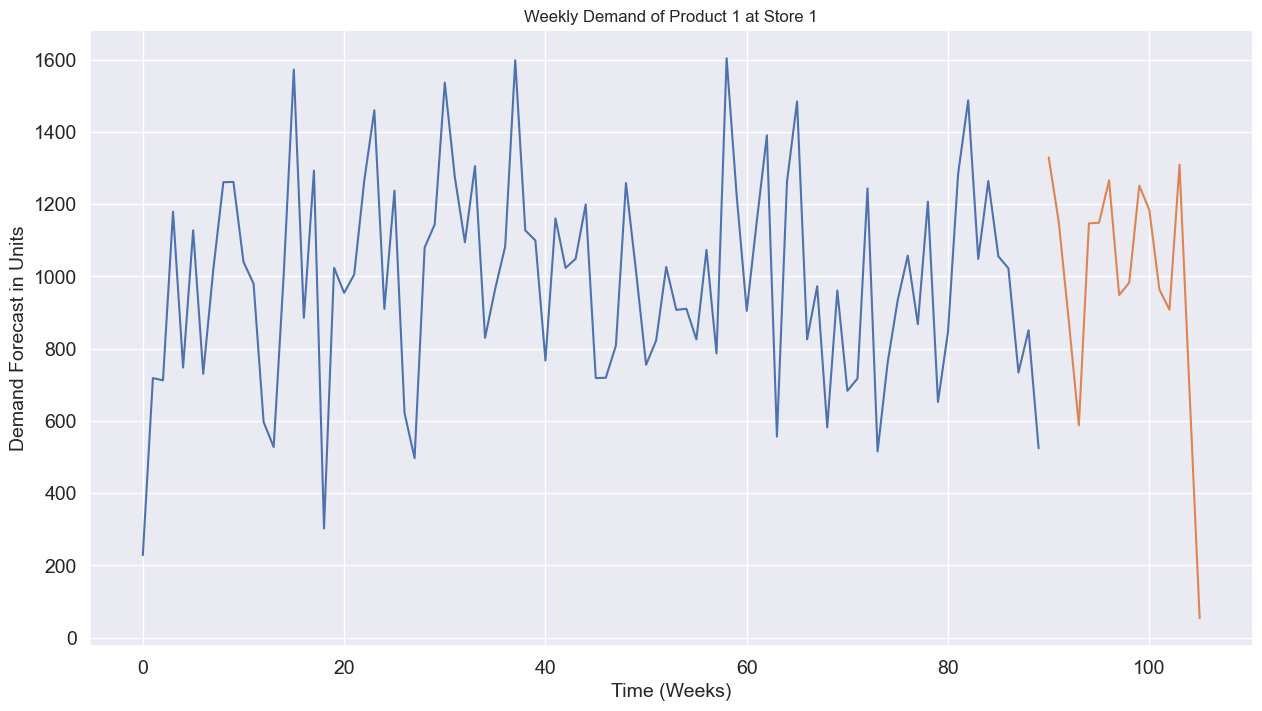

In [78]:
train.Demand_Forecast.plot(figsize=(15,8), title= 'Weekly Demand of Product 1 at Store 1', fontsize=14)
test.Demand_Forecast.plot(figsize=(15,8), title= 'Weekly Demand of Product 1 at Store 1', fontsize=14)

plt.xlabel('Time (Weeks)', fontsize=14)  
plt.ylabel('Demand Forecast in Units', fontsize=14) 

plt.show()

In [79]:
Weekly_Demand.nunique()

Date                  106
Inventory_Level       102
Units_Sold            103
Units_Ordered          91
Demand_Forecast       106
Price                 105
Discount               17
HolidayorPromotion      2
Competitor_Pricing    106
dtype: int64

In [80]:
Weekly_Demand

,Date,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
0,2022-01-02,347,208,159,228.41,61.45,30,0,60.58
1,2022-01-09,1474,706,977,718.59,422.10,90,1,412.21
2,2022-01-16,1276,686,1031,712.51,369.88,70,1,374.38
3,2022-01-23,2056,1142,1051,1179.51,417.71,55,1,417.41
4,2022-01-30,1883,685,740,747.78,457.95,80,1,463.72
...,...,...,...,...,...,...,...,...,...
101,2023-12-10,1561,904,559,963.89,408.44,30,1,415.08
102,2023-12-17,1528,805,989,908.22,398.86,100,1,399.27
103,2023-12-24,2662,1285,666,1309.76,258.88,70,1,250.47
104,2023-12-31,1408,619,643,677.95,279.53,55,1,286.28


### Feature Importance 

In [81]:

Weekly_Demand_prescale = Weekly_Demand.copy()
columns_to_scale = ['Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Price', 'Discount', 'Competitor_Pricing']

scaler = MinMaxScaler()
Weekly_Demand[columns_to_scale] = scaler.fit_transform(Weekly_Demand[columns_to_scale])


In [82]:
Weekly_Demand

,Date,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
0,2022-01-02,0.046028,0.109518,0.068894,228.41,0.012097,0.166667,0,0.002364
1,2022-01-09,0.464365,0.434159,0.922756,718.59,0.716918,0.833333,1,0.689208
2,2022-01-16,0.390869,0.421121,0.979123,712.51,0.614864,0.611111,1,0.615314
3,2022-01-23,0.680401,0.718383,1.000000,1179.51,0.708339,0.444444,1,0.699365
4,2022-01-30,0.616184,0.420469,0.675365,747.78,0.786980,0.722222,1,0.789823
...,...,...,...,...,...,...,...,...,...
101,2023-12-10,0.496659,0.563233,0.486430,963.89,0.690223,0.166667,1,0.694814
102,2023-12-17,0.484410,0.498696,0.935282,908.22,0.671500,0.944444,1,0.663932
103,2023-12-24,0.905345,0.811604,0.598121,1309.76,0.397936,0.611111,1,0.373279
104,2023-12-31,0.439866,0.377445,0.574113,677.95,0.438293,0.444444,1,0.443227


Text(0.5, 0, 'Feature Importance')

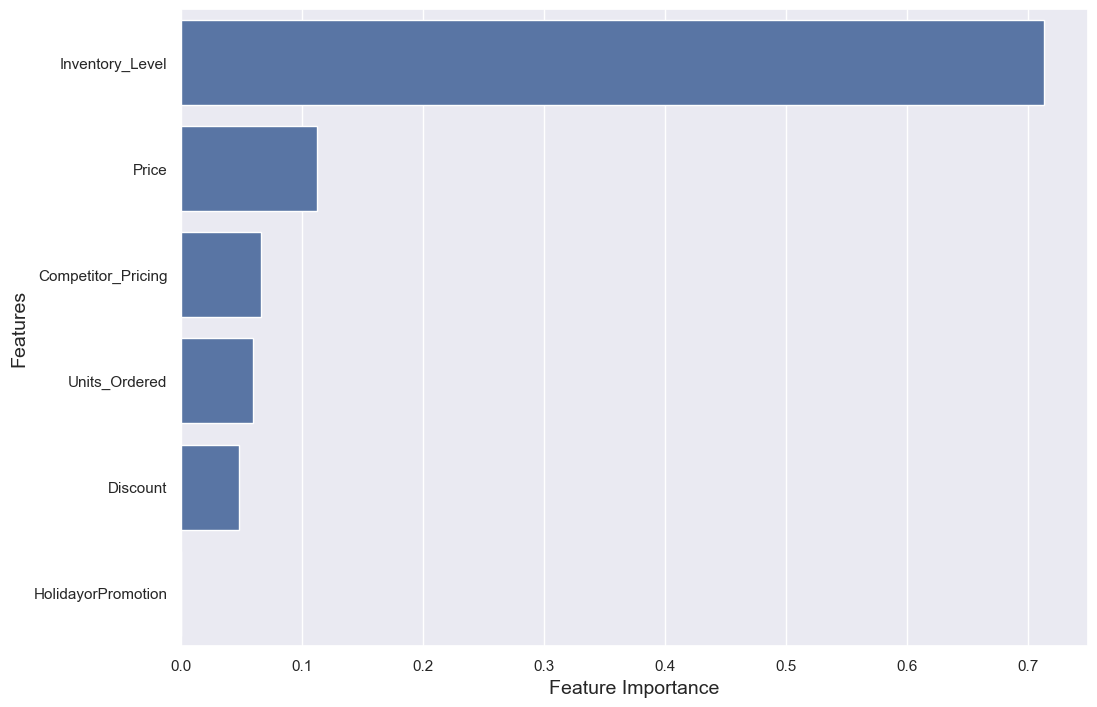

In [83]:
X = Weekly_Demand.drop(['Date','Demand_Forecast', 'Units_Sold'], axis= 1)
y = Weekly_Demand.drop(['Inventory_Level', 'Units_Sold', 'Units_Ordered','Price', 'Discount', 'HolidayorPromotion','Competitor_Pricing', 'Date'], axis= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


clf = DecisionTreeRegressor(criterion='friedman_mse')  
clf = clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=sorted_importances, y=sorted_feature_names, )
plt.ylabel("Features", fontsize=14)  

plt.xlabel("Feature Importance", fontsize=14)



We want to check if were understocked or overstocked for a product

In [84]:
Weekly_Demand.columns

Index(['Date', 'Inventory_Level', 'Units_Sold', 'Units_Ordered',
       'Demand_Forecast', 'Price', 'Discount', 'HolidayorPromotion',
       'Competitor_Pricing'],
      dtype='object')

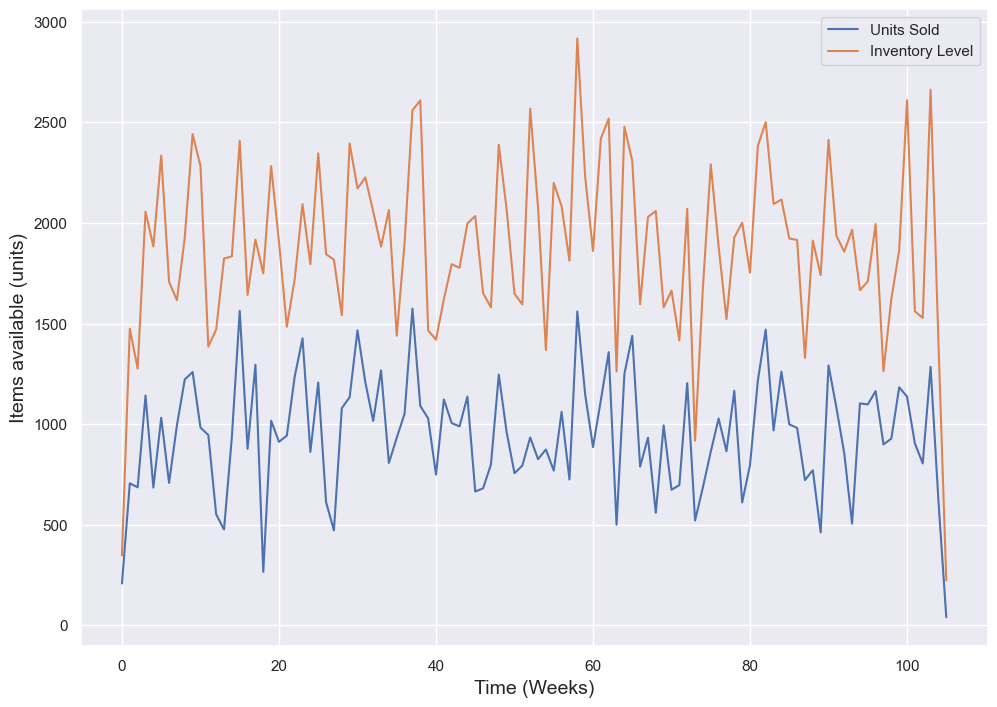

In [85]:
plt.plot(Weekly_Demand_prescale['Units_Sold'], label='Units Sold')
plt.plot(Weekly_Demand_prescale['Inventory_Level'], label='Inventory Level')

plt.xlabel('Time (Weeks)', fontsize=14)  
plt.ylabel('Items available (units)', fontsize=14) 

plt.legend()


### Next we want to see how overstocked we are

In [86]:
Weekly_Demand_prescale['stock_difference'] = Weekly_Demand_prescale['Inventory_Level'] - Weekly_Demand_prescale['Units_Sold']

In [87]:
Weekly_Demand_prescale

,Date,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing,stock_difference
0,2022-01-02,347,208,159,228.41,61.45,30,0,60.58,139
1,2022-01-09,1474,706,977,718.59,422.10,90,1,412.21,768
2,2022-01-16,1276,686,1031,712.51,369.88,70,1,374.38,590
3,2022-01-23,2056,1142,1051,1179.51,417.71,55,1,417.41,914
4,2022-01-30,1883,685,740,747.78,457.95,80,1,463.72,1198
...,...,...,...,...,...,...,...,...,...,...
101,2023-12-10,1561,904,559,963.89,408.44,30,1,415.08,657
102,2023-12-17,1528,805,989,908.22,398.86,100,1,399.27,723
103,2023-12-24,2662,1285,666,1309.76,258.88,70,1,250.47,1377
104,2023-12-31,1408,619,643,677.95,279.53,55,1,286.28,789


In [88]:

Weekly_Price = sp1_filtered_reset.resample('W').mean()
Weekly_Price = Weekly_Price.reset_index().head()


In [89]:
Weekly_Price

,Date,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,HolidayorPromotion,Competitor_Pricing
0,2022-01-02,173.500000,104.000000,79.500000,114.205000,30.725000,15.000000,0.000000,30.290000
1,2022-01-09,210.571429,100.857143,139.571429,102.655714,60.300000,12.857143,0.714286,58.887143
2,2022-01-16,182.285714,98.000000,147.285714,101.787143,52.840000,10.000000,0.571429,53.482857
3,2022-01-23,293.714286,163.142857,150.142857,168.501429,59.672857,7.857143,0.428571,59.630000
4,2022-01-30,269.000000,97.857143,105.714286,106.825714,65.421429,11.428571,0.714286,66.245714


since it looks like we have quite a big issue with overstocking, lets see how much revenue we lose due to it taking a usually 50% markup from https://smallbusiness.chron.com/normal-markup-percentage-80750.html

In [90]:
((Weekly_Demand_prescale['stock_difference'] * Weekly_Price['Price']).sum())/150*100

143115.09190476188

In [91]:
((Weekly_Demand_prescale['stock_difference'] * Weekly_Price['Price']).sum()/106)/150*100

1350.1423764600179

### Check for missing Values

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store_ID            73100 non-null  object        
 2   Product_ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory_Level     73100 non-null  int64         
 6   Units_Sold          73100 non-null  int64         
 7   Units_Ordered       73100 non-null  int64         
 8   Demand_Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather_Condition   73100 non-null  object        
 12  HolidayorPromotion  73100 non-null  int64         
 13  Competitor_Pricing  73100 non-null  float64   

from the following there seems to be no null instance so we can move on.